<a href="https://colab.research.google.com/github/zexross/self-driving-approaches/blob/master/nvidia-end-to-end-approach/self_driving_model(nvidia_approach).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import os
import cv2
import zipfile
import pandas as pd
import tensorflow as tf
import skimage.transform as sktransform
import random
import matplotlib.image as mpimg
import shutil
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten, Lambda
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn import model_selection
from datetime import datetime

In [17]:
!wget --no-check-certificate \
    https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip \
    -O /tmp/data.zip

# Extracting the Zip file contents to the folder "/tmp"
local_zip = '/tmp/data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-08-12 09:03:19--  https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip
Resolving d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)... 13.224.164.213, 13.224.164.107, 13.224.164.43, ...
Connecting to d17h27t6h515a5.cloudfront.net (d17h27t6h515a5.cloudfront.net)|13.224.164.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 333137665 (318M) [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip       100%[===================>] 317.70M   176MB/s    in 1.8s    

2020-08-12 09:03:21 (176 MB/s) - ‘/tmp/data.zip’ saved [333137665/333137665]



In [18]:
path = '/tmp/data'

cameras = ['left', 'center', 'right']
cameras_steering_correction = [0.25, 0.0, -0.25]

In [19]:
def preprocess(image, top_offset=.375, bottom_offset=.125):
    """
    Applies preprocessing pipeline to an image: crops `top_offset` and `bottom_offset`
    portions of image, resizes to 66x200 px and scales pixel values to [0, 1].
    """
    top = int(top_offset * image.shape[0])
    bottom = int(bottom_offset * image.shape[0])
    image = sktransform.resize(image[top:-bottom, :], (66, 200, 3))
    return image

In [20]:
def random_shear(image, steering_angle, shear_range=150):
    """
    Source: https://medium.com/@ksakmann/behavioral-cloning-make-a-car-drive-like-yourself-dc6021152713#.7k8vfppvk
    :param image:
        Source image on which the shear operation will be applied
    :param steering_angle:
        The steering angle of the image
    :param shear_range:
        Random shear between [-shear_range, shear_range + 1] will be applied
    :return:
        The image generated by applying random shear on the source image
    """
    rows, cols, ch = image.shape
    dx = np.random.randint(-shear_range, shear_range + 1)
    random_point = [cols / 2 + dx, rows / 2]
    pts1 = np.float32([[0, rows], [cols, rows], [cols / 2, rows / 2]])
    pts2 = np.float32([[0, rows], [cols, rows], random_point])
    dsteering = dx / (rows / 2) * 360 / (2 * np.pi * 25.0) / 6.0
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, (cols, rows), borderMode=1)
    steering_angle += dsteering

    return image, steering_angle

In [21]:
def random_trans(image,steer,trans_range = 100):
    """
    Source: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9#.jqcy5fcw6
    """
    # Translation
    rows, cols, ch = image.shape
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,steer_ang

In [22]:
def flip( x, y):

    print("distribution before processing")
    plt.figure();
    pd.Series(y).plot.hist(bins=101,alpha=0.5)

    flip_indices = random.sample(range(x.shape[0]), int(x.shape[0] / 2))
    x[flip_indices] = x[flip_indices, :, ::-1, :]
    y[flip_indices] = -y[flip_indices]

    print("distribution before processing")
    plt.figure();
    pd.Series(y).plot.hist(bins=101,alpha=0.5)
    return (x,y)

In [23]:
def make_dataset( dataset, train = True):
    data_length = len(dataset)
    x = []
    y = []
    for i in range(data_length):
        val = dataset.steering.values[i]
        j = np.random.randint(len(cameras)) if train else 1

        # add images to list
        image = preprocess(mpimg.imread(os.path.join(path, dataset[cameras[j]].values[i].strip())))
        steering = val + cameras_steering_correction[j]
        x.append(image)
        y.append(steering)

        transform_decide = random.randint(0,3)
        # add images with sheer
        if transform_decide == 1:
            sheer_image, sheer_steer = random_shear(image, steering)
            x.append(sheer_image)
            y.append(sheer_steer)
        
        # add images with transformation
        if transform_decide == 3:
            trans_image, trans_steer = random_trans(image, steering)
            x.append(trans_image)
            y.append(trans_steer)

    plt.figure()
    plt.imshow(x[5])
    x = np.array(x)
    y = np.array(y)
    return flip(x, y)

distribution before processing
distribution before processing
Training Data acquired!
distribution before processing
distribution before processing
Validation Data acquired!
Data acquired!


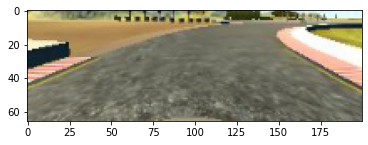

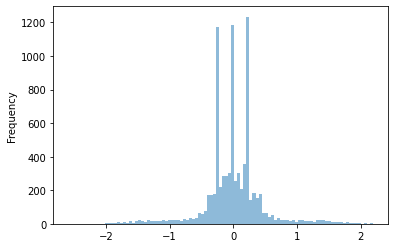

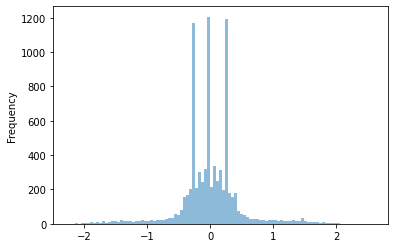

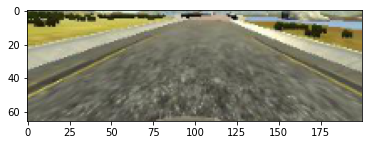

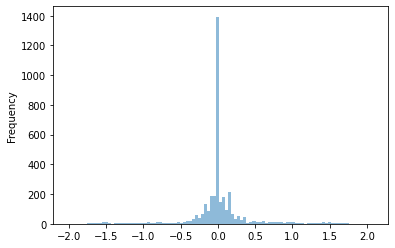

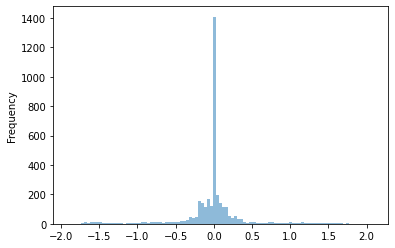

In [24]:
test_size = 0.3

df = pd.read_csv(os.path.join(path, 'driving_log.csv'))
train, valid = model_selection.train_test_split(df, test_size=test_size)
train_x , train_y = make_dataset(train)
#print(len(train_y))
#print(sum(train_y > 0))
print("Training Data acquired!")

valid_x , valid_y = make_dataset(valid , False)
print("Validation Data acquired!")

print("Data acquired!")

In [25]:
# Model architecture from NVIDIA Research Paper
model = Sequential()
model.add(Lambda(lambda x: x, input_shape=(66, 200, 3)))
model.add(Conv2D(24, 5, strides = (2,2), input_shape=(66, 200, 3), activation='relu'))
model.add(Conv2D(36, 5, strides = (2,2), input_shape=(31, 98, 24), activation='relu'))
model.add(Conv2D(48, 5, strides = (2,2), input_shape=(14, 47, 36), activation='relu'))
model.add(Conv2D(64, 3, input_shape=(5, 22, 48), activation='relu'))
model.add(Conv2D(64, 3, input_shape=(3, 20, 64), activation='relu'))
model.add(Flatten())
model.add(Dense(1164, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=Adam(lr=1e-04), loss= "log_cosh", metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

In [26]:
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1, factor=0.2, min_lr=1e-6)

# more image augmentation
datagen = ImageDataGenerator(brightness_range = (0.7,0.9))
datagen.fit(train_x)

In [27]:
history = model.fit(
    datagen.flow(train_x,train_y, batch_size = 32),
    epochs=12,
    validation_data= (valid_x, valid_y),
    callbacks=[reduce_lr]
)

Epoch 1/12
262/262 [==============================] - 9s 34ms/step - loss: 0.1457 - accuracy: 0.1154 - val_loss: 0.0790 - val_accuracy: 0.3596
Epoch 2/12
262/262 [==============================] - 8s 29ms/step - loss: 0.0693 - accuracy: 0.1198 - val_loss: 0.0790 - val_accuracy: 0.3596
Epoch 3/12
262/262 [==============================] - 7s 29ms/step - loss: 0.0585 - accuracy: 0.1199 - val_loss: 0.0790 - val_accuracy: 0.3596
Epoch 4/12
262/262 [==============================] - 7s 28ms/step - loss: 0.0497 - accuracy: 0.1199 - val_loss: 0.0791 - val_accuracy: 0.3596
Epoch 5/12
262/262 [==============================] - 7s 28ms/step - loss: 0.0432 - accuracy: 0.1200 - val_loss: 0.0789 - val_accuracy: 0.3596
Epoch 6/12
262/262 [==============================] - 7s 28ms/step - loss: 0.0389 - accuracy: 0.1200 - val_loss: 0.0790 - val_accuracy: 0.3596
Epoch 7/12
262/262 [==============================] - 7s 28ms/step - loss: 0.0345 - accuracy: 0.1200 - val_loss: 0.0785 - val_accuracy: 0.3596

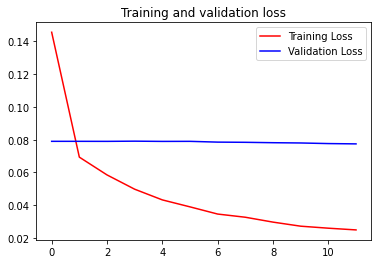

In [28]:
# Extracting the values of accuracy and loss from our model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
# Plotting the Training and validation loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()